In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/bank-marketing-dataset/bank.csv


Firstly, lets start from reading the dataset and looking it's info and numerical feature statistics

In [2]:
data = pd.read_csv("/kaggle/input/bank-marketing-dataset/bank.csv")
print(data.info())
print(data.describe().T)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11162 non-null  int64 
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(7), object(10)
memory usage: 1.4+ MB
None
            count         mean          std     min    25%    50%      75%  \
age       11162.

So, in this dataset, we are provided with client data. Our target variable is deposit, and the task is to predict, whether some specific client will get a long term deposit or not. As it is a binary variable, it means that we are dealing with classification problem



We see that there are no missing data in our dataset, this is very good for us because linear models tend to work worse with it

Now, lets look at the distribution of this target variable, to see if it is balanced, or not.

<Axes: xlabel='deposit'>

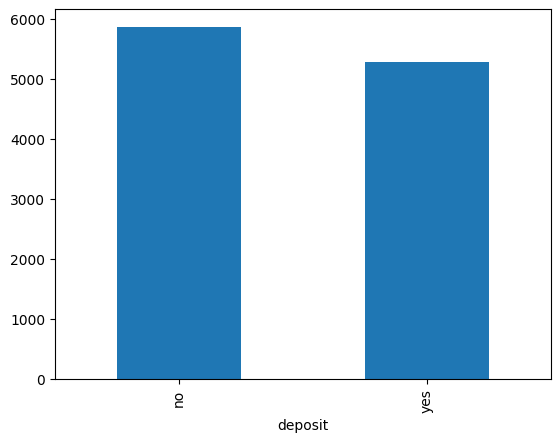

In [3]:
data.deposit.value_counts().plot(kind='bar')

We see that our target's distribution is balanced, it's good news for us, because it means that our model won't result in high bias

Now, lets start preprocessing our data by first looking at our object variables and determining whether they are ordinal or categorical



In [4]:
object_cols = ["job", "marital", "education", "default", 
               "housing", "loan", "contact", "month", "deposit", "poutcome"]
for col in object_cols:
    print(data[col].value_counts())
    print("\n\n")

job
management       2566
blue-collar      1944
technician       1823
admin.           1334
services          923
retired           778
self-employed     405
student           360
unemployed        357
entrepreneur      328
housemaid         274
unknown            70
Name: count, dtype: int64



marital
married     6351
single      3518
divorced    1293
Name: count, dtype: int64



education
secondary    5476
tertiary     3689
primary      1500
unknown       497
Name: count, dtype: int64



default
no     10994
yes      168
Name: count, dtype: int64



housing
no     5881
yes    5281
Name: count, dtype: int64



loan
no     9702
yes    1460
Name: count, dtype: int64



contact
cellular     8042
unknown      2346
telephone     774
Name: count, dtype: int64



month
may    2824
aug    1519
jul    1514
jun    1222
nov     943
apr     923
feb     776
oct     392
jan     344
sep     319
mar     276
dec     110
Name: count, dtype: int64



deposit
no     5873
yes    5289
Name: count, dtype: 

So, the binary variables for us are deposit, loan, housing and default, we will replace them with ones and zeroes

In [5]:
binary_variables = ["deposit", "loan", "housing","default"]
for var in binary_variables:
    data[var] = data[var].map({"yes" : 1, "no" : 0})
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  int64 
 5   balance    11162 non-null  int64 
 6   housing    11162 non-null  int64 
 7   loan       11162 non-null  int64 
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  int64 
dtypes: int64(11), object(6)
memory usage: 1.4+ MB


Now, lets look at ordinal variables, in our example, they are education and poutcome, we can't just one-hot encode them, because order matters, so we will preprocess them like this

In [6]:
education_dict = {
    "unknown" : 0, 
    "primary" : 1, 
    "secondary" : 2, 
    "tertiary" : 3
}
data["education"] = data["education"].map(education_dict)
data["education"].value_counts()

education
2    5476
3    3689
1    1500
0     497
Name: count, dtype: int64

In [7]:
poutcome_dict = {
    "unknown" : 0, 
    "failure" : 1, 
    "other" : 2, 
    "success" : 3
}
data["poutcome"] = data["poutcome"].map(poutcome_dict)
data["poutcome"].value_counts()

poutcome
0    8326
1    1228
3    1071
2     537
Name: count, dtype: int64

Now, lets one-hot encode the categorical variables



In [8]:
data = pd.get_dummies(data, columns=["job", "marital", "contact", "month"])


In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 43 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   age                11162 non-null  int64
 1   education          11162 non-null  int64
 2   default            11162 non-null  int64
 3   balance            11162 non-null  int64
 4   housing            11162 non-null  int64
 5   loan               11162 non-null  int64
 6   day                11162 non-null  int64
 7   duration           11162 non-null  int64
 8   campaign           11162 non-null  int64
 9   pdays              11162 non-null  int64
 10  previous           11162 non-null  int64
 11  poutcome           11162 non-null  int64
 12  deposit            11162 non-null  int64
 13  job_admin.         11162 non-null  bool 
 14  job_blue-collar    11162 non-null  bool 
 15  job_entrepreneur   11162 non-null  bool 
 16  job_housemaid      11162 non-null  bool 
 17  job_manageme

Now, lets scale our numerical features

In [10]:
num_features = ["age", "balance", "day", "duration",
                "campaign", "pdays", "previous", 
                "poutcome", "education"]

In [11]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
data[num_features] = scaler.fit_transform(data[num_features])
data.describe().T

,count,mean,std,min,25%,50%,75%,max
age,11162.0,0.301714,0.154719,0.0,0.181818,0.272727,0.402597,1.0
education,11162.0,0.702353,0.264907,0.0,0.666667,0.666667,1.000000,1.0
default,11162.0,0.015051,0.121761,0.0,0.000000,0.000000,0.000000,1.0
balance,11162.0,0.095121,0.036631,0.0,0.079147,0.084008,0.097160,1.0
housing,11162.0,0.473123,0.499299,0.0,0.000000,0.000000,1.000000,1.0
loan,11162.0,0.130801,0.337198,0.0,0.000000,0.000000,0.000000,1.0
day,11162.0,0.488601,0.280691,0.0,0.233333,0.466667,0.700000,1.0
duration,11162.0,0.095384,0.089489,0.0,0.035061,0.065223,0.127352,1.0
campaign,11162.0,0.024329,0.043904,0.0,0.000000,0.016129,0.032258,1.0
pdays,11162.0,0.061205,0.127203,0.0,0.000000,0.000000,0.025439,1.0


Great, now, lets split our data in training and test datasets

In [12]:
X, y = data.drop("deposit", axis=1), data.deposit


In [13]:
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=54)

And now, it's finally time to build and train our model



In [14]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)
y_pred = log_reg.predict(X_valid)

from sklearn.metrics import accuracy_score,r2_score, f1_score
print(f"Accuracy: {accuracy_score(y_valid, y_pred)}")
print(f"f1_score: {f1_score(y_valid, y_pred)}")

Accuracy: 0.8181818181818182
f1_score: 0.7974051896207585


Alright, so, we got a pretty decent accuracy score, which means that our model has answered correctly in 81% of scenarios, but we also got a good f1 score, which means for us that our model has a good balance between precision and recall.

Now, let's apply different kinds of regularization for our model, to prevent it from overfitting, and also to balance variance and bias.

# L1


In [15]:
from sklearn.model_selection import GridSearchCV
log_reg = LogisticRegression(solver='liblinear', penalty='l1')

C_values = {'C': np.logspace(-3, 3, 20)}
logreg_grid = GridSearchCV(log_reg, C_values, cv=5, scoring='f1')
logreg_grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=LogisticRegression(penalty='l1', solver='liblinear'),
             param_grid={'C': array([1.00000000e-03, 2.06913808e-03, 4.28133240e-03, 8.85866790e-03,
       1.83298071e-02, 3.79269019e-02, 7.84759970e-02, 1.62377674e-01,
       3.35981829e-01, 6.95192796e-01, 1.43844989e+00, 2.97635144e+00,
       6.15848211e+00, 1.27427499e+01, 2.63665090e+01, 5.45559478e+01,
       1.12883789e+02, 2.33572147e+02, 4.83293024e+02, 1.00000000e+03])},
             scoring='f1')

In [16]:
print(logreg_grid.best_params_)
print(logreg_grid.best_score_)

{'C': 1.438449888287663}
0.8104435823440685


In [17]:
results_df = pd.DataFrame(logreg_grid.cv_results_)
print(results_df)

    mean_fit_time  std_fit_time  mean_score_time  std_score_time     param_C  \
0        0.031269      0.006420         0.012280        0.001216       0.001   
1        0.034181      0.000459         0.012800        0.000178    0.002069   
2        0.042099      0.001776         0.013223        0.000117    0.004281   
3        0.043146      0.000808         0.013101        0.000180    0.008859   
4        0.056331      0.003904         0.013152        0.000159     0.01833   
5        0.066485      0.001653         0.013459        0.000358    0.037927   
6        0.092766      0.004730         0.013270        0.000136    0.078476   
7        0.127570      0.011593         0.010701        0.001278    0.162378   
8        0.160506      0.010855         0.009131        0.001040    0.335982   
9        0.234985      0.018258         0.009730        0.000156    0.695193   
10       0.436826      0.073539         0.009772        0.000168     1.43845   
11       0.686869      0.046069         

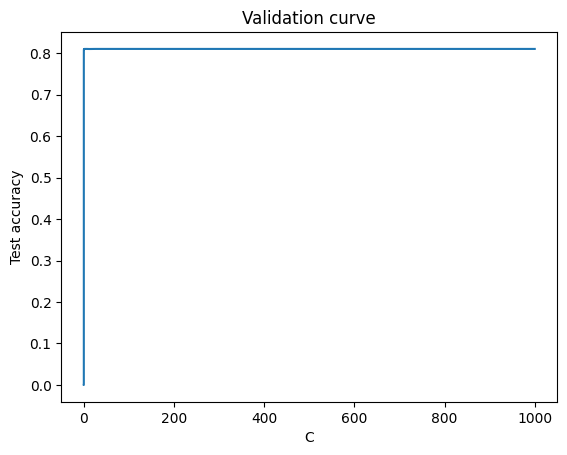

In [18]:
import matplotlib.pyplot as plt
results_df = pd.DataFrame(logreg_grid.cv_results_)
plt.plot(results_df['param_C'], results_df['mean_test_score'])


plt.xlabel('C')
plt.ylabel('Test accuracy')
plt.title('Validation curve')
plt.show()

# L2

In [19]:
from sklearn.model_selection import GridSearchCV

log_reg = LogisticRegression(solver='liblinear')

C_values = {'C': np.logspace(-3, 3, 20)}
logreg_grid = GridSearchCV(log_reg, C_values, cv=5, scoring='f1')
logreg_grid.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(solver='liblinear'),
             param_grid={'C': array([1.00000000e-03, 2.06913808e-03, 4.28133240e-03, 8.85866790e-03,
       1.83298071e-02, 3.79269019e-02, 7.84759970e-02, 1.62377674e-01,
       3.35981829e-01, 6.95192796e-01, 1.43844989e+00, 2.97635144e+00,
       6.15848211e+00, 1.27427499e+01, 2.63665090e+01, 5.45559478e+01,
       1.12883789e+02, 2.33572147e+02, 4.83293024e+02, 1.00000000e+03])},
             scoring='f1')

In [20]:
print(logreg_grid.best_params_)
print(logreg_grid.best_score_)

{'C': 26.366508987303554}
0.8107629173628783


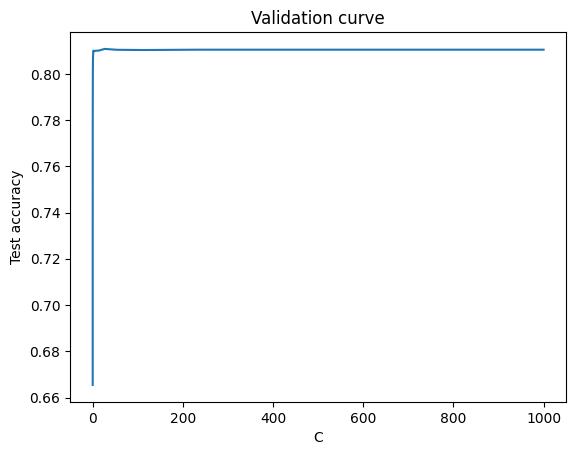

In [21]:
results_df = pd.DataFrame(logreg_grid.cv_results_)
plt.plot(results_df['param_C'], results_df['mean_test_score'])

# Подписываем оси и график
plt.xlabel('C')
plt.ylabel('Test accuracy')
plt.title('Validation curve')
plt.show()

# ElasticNet

In [22]:
from sklearn.model_selection import GridSearchCV

log_reg = LogisticRegression(solver='saga', penalty='elasticnet')

C_values = {'C': np.logspace(-3, 3, 20), "l1_ratio" : [0.1, 0.3, 0.5, 0.7, 0.9]}
logreg_grid = GridSearchCV(log_reg, C_values, cv=5, scoring='f1')
logreg_grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=LogisticRegression(penalty='elasticnet', solver='saga'),
             param_grid={'C': array([1.00000000e-03, 2.06913808e-03, 4.28133240e-03, 8.85866790e-03,
       1.83298071e-02, 3.79269019e-02, 7.84759970e-02, 1.62377674e-01,
       3.35981829e-01, 6.95192796e-01, 1.43844989e+00, 2.97635144e+00,
       6.15848211e+00, 1.27427499e+01, 2.63665090e+01, 5.45559478e+01,
       1.12883789e+02, 2.33572147e+02, 4.83293024e+02, 1.00000000e+03]),
                         'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9]},
             scoring='f1')

In [23]:
print(logreg_grid.best_params_)
print(logreg_grid.best_score_)

{'C': 26.366508987303554, 'l1_ratio': 0.1}
0.8109025804100491


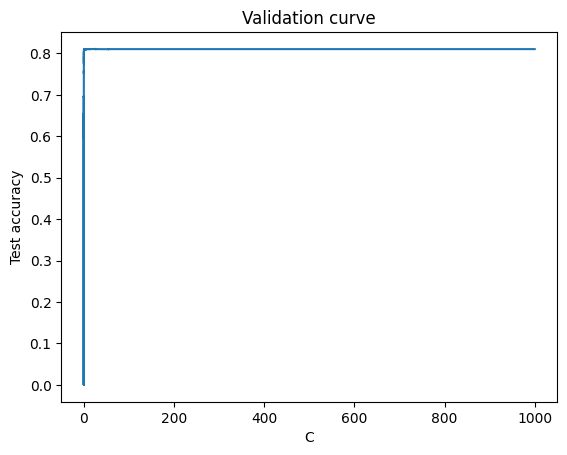

In [24]:
results_df = pd.DataFrame(logreg_grid.cv_results_)
plt.plot(results_df['param_C'], results_df['mean_test_score'])

# Подписываем оси и график
plt.xlabel('C')
plt.ylabel('Test accuracy')
plt.title('Validation curve')
plt.show()

Alright, so, the best performing model in terms of f1 score is our Elasticnet regularized model with such hyperparameters

{'C': 26.366508987303554, 'l1_ratio': 0.1}

It provided us with a 0.81 f1 score

Now, let's take a look at our model's coefficients

In [25]:
log_reg_best = logreg_grid.best_estimator_
y_pred = log_reg_best.predict(X_valid)
print(f"Accuracy: {accuracy_score(y_valid, y_pred)}")
print(f"f1_score: {f1_score(y_valid, y_pred)}")

Accuracy: 0.8199731303179579
f1_score: 0.8009900990099009


In [26]:
feature_names = X_train.columns
coefficients = log_reg_best.coef_[0]
coefficients_tuples = list(zip(feature_names, coefficients))
sorted_coefficients = sorted(coefficients_tuples, key=lambda x: abs(x[1]), reverse=True)
for feature, coef in sorted_coefficients:
    print(f"{feature}: {coef}")

duration: 21.309958953977862
campaign: -5.9300437342821315
poutcome: 2.4427983736455636
previous: -2.009967900551449
balance: 1.8316145657032967
month_mar: 1.8310694618316463
contact_unknown: -1.3831295573763664
month_jan: -1.345946842629895
month_dec: 1.2762878181963193
pdays: -1.2015826044571105
month_nov: -1.1457262732039633
month_jul: -1.140103464839989
month_aug: -0.974013511258346
month_oct: 0.9335853199240656
month_may: -0.8808854813457
month_sep: 0.8032371670717926
job_student: 0.6799763926717733
housing: -0.6738187485887002
job_self-employed: -0.49078995174871987
education: 0.4854918937853692
loan: -0.4776215887536824
marital_married: -0.4610985369497998
job_retired: 0.3431847058721204
month_feb: -0.3219278833985198
job_blue-collar: -0.3011650008344351
marital_divorced: -0.2938649338332133
job_entrepreneur: -0.2671400335759195
job_housemaid: -0.19747828700295073
contact_telephone: 0.1890429681368366
marital_single: -0.18506035966384818
contact_cellular: 0.18391467654966678
job

Alright, we can see that our most significant features are duration, campaign, poutcome. It is very simular to the feature significance we got from our decision tree model.